## 数据

In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
prostate = pd.read_csv("../../../datasets/prostate/prostate.data", 
                       sep="\t", index_col=0)
prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [3]:
train_data = prostate.drop("train", axis=1)[prostate["train"] == "T"]
test_data = prostate.drop("train", axis=1)[prostate["train"] == "F"]

scaler = StandardScaler().fit(train_data)
train_data_std = scaler.fit_transform(train_data)
test_data_std = scaler.transform(test_data)
X_train = train_data_std[:, :-1]
y_train = train_data_std[:, -1]
X_test = test_data_std[:, :-1]
y_test = test_data_std[:, -1]

## 向前选择

In [36]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [24]:
p = X_train.shape[1]
feature_names = list(train_data.columns)[:-1]
lr = LinearRegression()
sfs = SFS(lr,
          k_features=p,
          forward=True, 
          floating=False,
          scoring='neg_mean_squared_error',
          cv=0)
sfs.fit(X_train, y_train, custom_feature_names=feature_names)

SequentialFeatureSelector(clone_estimator=True, cv=0,
                          estimator=LinearRegression(copy_X=True,
                                                     fit_intercept=True,
                                                     n_jobs=None,
                                                     normalize=False),
                          fixed_features=None, floating=False, forward=True,
                          k_features=8, n_jobs=1, pre_dispatch='2*n_jobs',
                          scoring='neg_mean_squared_error', verbose=0)

In [26]:
print("训练样本误差: {:.3f}".format(-sfs.k_score_ )) # 均方差

训练样本误差: 0.306


In [48]:
best_feature_idx = sfs.k_feature_idx_
X_trans = sfs.transform(X_test)
lr.fit(X_train[:, best_feature_idx], y_train)
y_pred = lr.predict(X_trans)
test_err = mean_squared_error(y_test, y_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.363


### 向前选择的过程

In [60]:
results = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
results

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)",[-0.46248353094471173],-0.462,"(lcavol,)",NaN,0.000,NaN
2,"(0, 1)",[-0.3852439649775568],-0.385,"(lcavol, lweight)",NaN,0.000,NaN
3,"(0, 1, 4)",[-0.3625594614828106],-0.363,"(lcavol, lweight, svi)",NaN,0.000,NaN
4,"(0, 1, 3, 4)",[-0.3408236627797711],-0.341,"(lcavol, lweight, lbph, svi)",NaN,0.000,NaN
5,"(0, 1, 3, 4, 7)",[-0.3330802453815048],-0.333,"(lcavol, lweight, lbph, svi, pgg45)",NaN,0.000,NaN
6,"(0, 1, 3, 4, 5, 7)",[-0.31719276879766206],-0.317,"(lcavol, lweight, lbph, svi, lcp, pgg45)",NaN,0.000,NaN
7,"(0, 1, 2, 3, 4, 5, 7)",[-0.3057421947901528],-0.306,"(lcavol, lweight, age, lbph, svi, lcp, pgg45)",NaN,0.000,NaN
8,"(0, 1, 2, 3, 4, 5, 6, 7)",[-0.3056288203231761],-0.306,"(lcavol, lweight, age, lbph, svi, lcp, gleason...",NaN,0.000,NaN


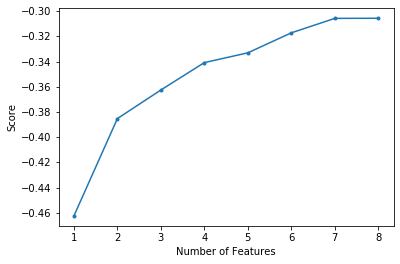

In [77]:
n_features = results["feature_idx"].apply(lambda x: len(x))
plt.plot(n_features, results["avg_score"], ".-")
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.show()